# DAY 55

在进入rnn相关变体的内容前，我们必须要搞懂序列任务的前生今世，这是我当初自学的时候非常迷茫和痛苦的，只有理解了序列任务，才知道模型为什么这么选择，数据为什么这么处理

## 一、序列预测任务介绍

### 1.1 序列预测是什么？

我们之前接触到的结构化数据，它本身不具备顺序，我们认为每个样本之间独立无关，样本之间即使调换顺序，仍然不影响模型的训练。

但是日常中很多数据是存在先后关系的，而他们对应的任务是预测下一步的值，我们把这个任务称之为序列预测。

举个例子，比如有过去30天的股票价格，我们希望预测第31天的价格。比如之前的单车预测，有前60天的单车需求数据，希望预测后面20天的销量。或者文本，人的语言是有顺序的，预测下一个单词是这也是序列预测任务。

### 1.2 序列预测的x-y对

那么如何把之前结构化的数据，转化为序列的样子呢？

答案就是通过滑动窗口这个方式来实现。序列任务也需要有自己的数据对，这样才符合监督学习的训练。把原始数据序列，转化为x-y这样的标签对，实现用前seq_length个时间步预测下一个时间步的监督学习格式。

假设原始数据 data = [10, 20, 30, 40, 50, 60, 70, 80, 90]，

序列长度 seq_length = 3

这个x-y序列对如下

```python
X = [
  [10, 20, 30],  # 用前3步预测第4步
  [20, 30, 40],  # 用2-4步预测第5步
  [30, 40, 50],  # 用3-5步预测第6步
  [40, 50, 60],  # 用4-6步预测第7步
  [50, 60, 70],  # 用5-7步预测第8步
  [60, 70, 80]   # 用6-8步预测第9步
]

y = [40, 50, 60, 70, 80, 90]  # 每个X对应的下一个值
```

其中第一个x-y对是[10, 20, 30]-->[40]，第二个x-y对是[20, 30, 40]-->[50]，第三个x-y对是[30, 40, 50]-->[60]，第四个x-y对是[40, 50, 60]-->[70]，第五个x-y对是[50, 60, 70]-->[80]，第六个x-y对是[60, 70, 80]-->[90]。这个样本对，和我们之前结构化数据见到的样本-标签对 是一个逻辑。


注意，最后三个值 [70, 80, 90] 不能作为输入（因为没有后续值作为目标），所以生成的样本数为 len(data) - seq_length = 9 - 3 = 6
```python
可以把上述过程理解为一个尺寸为3的窗口在滑动的过程（类似于卷积核滑动），

滑动窗口过程:
[10, 20, 30] → 40
   [20, 30, 40] → 50
      [30, 40, 50] → 60
         [40, 50, 60] → 70
            [50, 60, 70] → 80
               [60, 70, 80] → 90
```


### 1.3 序列预测的标准输入

一个标准的序列数据张量通常具有三个维度：[批量大小, 序列长度, 特征维度]

批量大小 (Batch Size)：一次性喂给模型多少个独立的样本进行处理
序列长度 (Sequence Length / Timesteps)：每个样本的序列长度，即该样本的序列长度是多少

## 二、基础概念



### 2.1 准备工作

In [17]:
# 准备工作

import numpy as np
import random
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# 显示中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 显示负号正常
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings("ignore")

# 设置随机种子确保结果可复现，全局随机函数
def set_seed(seed=42, deterministic=True):
    """
    设置全局随机种子，确保实验可重复性
    
    参数:
        seed: 随机种子值，默认为42
        deterministic: 是否启用确定性模式，默认为True
    """
    # 设置Python的随机种子
    random.seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed) # 确保Python哈希函数的随机性一致，比如字典、集合等无序
    
    # 设置NumPy的随机种子
    np.random.seed(seed)
    
    # 设置PyTorch的随机种子
    torch.manual_seed(seed) # 设置CPU上的随机种子
    torch.cuda.manual_seed(seed) # 设置GPU上的随机种子
    torch.cuda.manual_seed_all(seed)  # 如果使用多GPU
    
    # 配置cuDNN以确保结果可重复
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


# 设置随机种子
set_seed(42)

### 2.2 数据生成

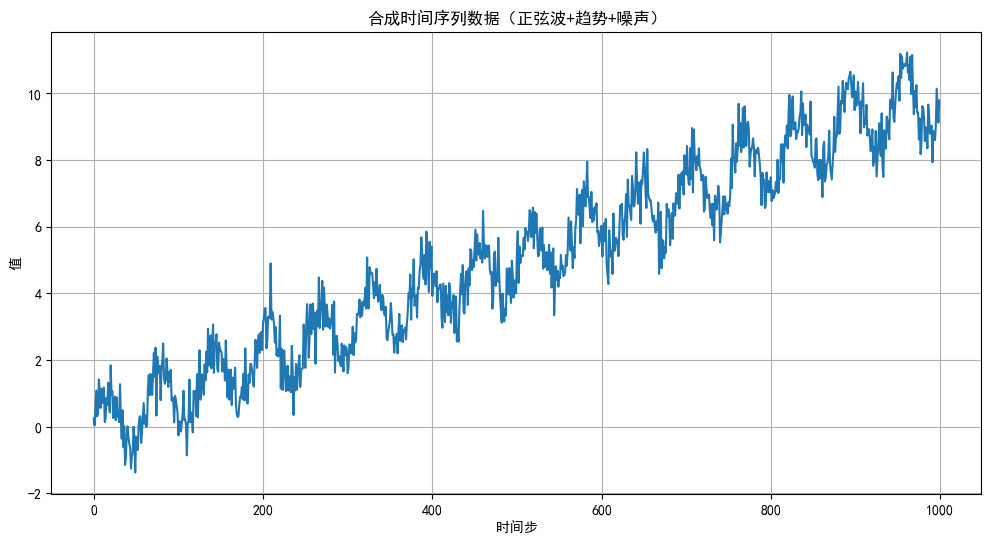

In [18]:
# ===== 步骤1：生成合成时间序列 =====
x = np.linspace(0, 100, 1000) # 在 0 到 100 之间生成 1000 个均匀分布的点作为x
y = np.sin(x) + 0.1 * x + np.random.normal(0, 0.5, 1000)  # 正弦波+线性趋势+噪声
# 可视化原始数据
plt.figure(figsize=(12, 6))
plt.plot(y)
plt.title('合成时间序列数据（正弦波+趋势+噪声）')
plt.xlabel('时间步')
plt.ylabel('值')
plt.grid(True)
plt.show()

为了演示序列预测，现在构建了一个近似于sinx的分布，我们后面将要做这个顺序预测，比如用前5个周期预测第六个周期的值。此时这前5个周期就是训练集，第6个周期就是测试集。



### 2.3 单步预测和多步预测概念

要注意此时训练集和测试集是有明确的时间顺序的，这是因为预测的任务是有顺序关系的。只有用历史数据来预测未来数据。

这个时候我们要明白，具体是如何预测的呢？比如现在有100个数据，80个训练，20个预测

过去我们再用机器学习预测结构化的独立同分布的样本的时候，这种预测是训练完模型后，每一个测试集的样本特征输入到模型后就会得到对应的标签。

但是现在不同，若没有第 n 个样本的标签，无法预测第 n+1 个样本，因为预测过程需基于历史序列的递推关系（如股票价格预测，需已知前一天价格才能推导出后一天趋势）


单步预测（Single-Step Prediction）：一次只预测下一时刻

训练集构建：若窗口大小为 5，训练样本形如 [x1,x2,x3,x4,x5]→x6，[x2,x3,x4,x5,x6]→x7，以此类推

此时只会预测到81个结束了，单步预测指的是只预测一个时刻，比如只预测未来一天的。


多步预测（Multi-Step Prediction）：一次预测多个时刻

2种方式
- 递归式多步预测（滚动预测）：先用预测第81天的，再用81天的预测数据和历史数据预测第82天的，以此类推，这种方式会造成误差的累计
- 直接式多步预测：构建模型直接输出未来多个时刻的值（如输入特征 x60-x80，标签 x81-x90），这样输出的是一次性的预测结果，不会累计误差

这种直接式的多步预测，也是我们第一次接触多输入多输出这种情况。我们之前做的回归任务，都是多输入单输出。

这种多输入多输出的任务叫做MIMO(Multiple-Input Multiple-Output)

### 2.4 多输入多输出任务

其实之前的结构化数据对应的非时序任务都可以完成多输入多少输出任务，比如
- 体检指标（血压、血糖、胆固醇）、病史、年龄
- 输出：是否患糖尿病（0/1）、冠心病风险（概率值）、肥胖等级（1-5）
此时选择什么模型呢？

传统的机器学习模型默认单输出，如线性回归、逻辑回归、SVM、决策树等经典算法，原生设计用于单输出任务（即预测一个目标变量）。随机森林貌似是支持多输出任务，但是总归大多不用他们来完成。

一般这类任务可以由算法上最为简单的神经网络来实现，有几种思路：

1. 把和这个任务拆分成多个任务，每个任务都是多输入单输出，缺点是有可能预测的标签之间可能有某些关系，比如同时预测“价格” 和 “面积” ，这2者可能有关，拆开作为2个机器学习模型分开预测可能丢失这种关系（独立建模）。
2. 通过神经网络，构建多输出模型，本质就是修改损失函数为多输出的损失函数（每个目标对应的权重如何分配也是个问题），这其实就是一个联合建模任务，我们在复试班的强化NLP中就提到bert本质就是这么一个联合建模任务，同时考虑到了MLM（掩码语言模型，多分类任务） 和NSP（下一句预测，二分类任务）的损失。




这种联合建模的思路，在后面大模型领域，将会不断遇到，自行梳理下我们课上说的知识点的演变逻辑。

## 三、 时序任务实战

### 3.1数据的划分

In [19]:
# ===== 步骤2：数据预处理 =====
# 1. 数据标准化
scaler = MinMaxScaler(feature_range=(0, 1)) # 创建将数据缩放到0-1范围的缩放器
scaled_y = scaler.fit_transform(y.reshape(-1, 1)).flatten() # 将y转换为二维数组并进行缩放，后续再将其展平为一维数组

这里之所以需要转换为二维数组，因为转换器要求输入是二维数组，形状为 [样本数, 特征数]

In [20]:
# 2. 划分训练集和测试集（80%训练，20%测试），时间序列任务要按时间顺序划分训练集和测试集
train_size = int(len(scaled_y) * 0.8)
train_data = scaled_y[:train_size]
test_data = scaled_y[train_size:]

# 3. 创建时序数据集函数
def create_sequences(data, seq_length):
    """
    将数据转换为适合RNN输入的序列格式
    参数:
        data: 原始时间序列数据
        seq_length: 每个输入序列的长度
    返回:
        X: 输入序列集
        y: 目标值集
    """
    X, y = [], [] # 初始化空列表存储输入序列和目标值
    for i in range(len(data) - seq_length): # 一共这么多个序列对
        X.append(data[i:i+seq_length]) # 截取长度为seq_length的子序列作为列表输入
        y.append(data[i+seq_length])  # 对应的下一个值作为目标
    return np.array(X), np.array(y) # 转换为NumPy数组返回

# 设置序列长度（使用前30个时间步预测下一个）
seq_length = 30

注意上面的代码是先划分训练集和测试集，再对各自数据集应用滑动窗口

这样写对么？上面这里的代码本来我是让豆包给我写的，你和他说他错了他还反驳你，难绷。

实际上他的处理逻辑是有问题的，这也要求你要自己知道流程，具备逻辑才可以正确处理任务。实际上，正确的做法是，先滑动窗口，再划分训练集和测试集。

豆包的做法：原始数据（时间顺序：1→2→…→100），假设滑动窗口是10
↓ 按时间划分（前80%训练，后20%测试）
训练集：1-80，测试集：81-100
↓ 对训练集和测试集分别应用滑动窗口
训练集滑动窗口：[1-10]→11，[2-11]→12，…，[71-80]→81
测试集滑动窗口：[81-90]→91，[82-91]→92，…，[91-100]→101

他这样会出现一个问题，有一段标签81-90这部分的标签没用上，所以在样本缺少的情况下，要先滑动窗口再划分。

此外，在正确的测试集中，比如[72-81]→82 是第一个，然后[73-82]→83，那么此时这里的82到底是用的预测的数据，还是真实数据呢？

实际上，用的是真实的数据，因为我们做的是单步预测，预测的前提就是知道之前的每一个值，预测明天的值。如果想要预测未来30天的值，应该考虑的是多步预测的2种方法

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# # ===== 步骤1：生成合成时间序列  =====
# x = np.linspace(0, 100, 1000)
# y = np.sin(x) + 0.1 * x + np.random.normal(0, 0.5, 1000)

# # =============================================================
# # =================== 正确流程的代码实现 ======================
# # =============================================================

# ===== 步骤2：划分原始数据，并进行正确的标准化 =====

# 1. 定义划分点
train_size = int(len(y) * 0.8)
seq_length = 30

# 2. 划分原始数据（仅用于fit缩放器）
train_data_raw = y[:train_size]
# 注意：测试集暂时不需要单独划分出来

# 3. 数据标准化 (关键步骤！)
#    - 创建缩放器
#    - 仅在训练数据上进行拟合(fit)，学习其分布
#    - 对整个数据集进行转换(transform)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data_raw.reshape(-1, 1))
scaled_y = scaler.transform(y.reshape(-1, 1)).flatten()

# ===== 步骤3：对完整的、缩放后的数据应用滑动窗口 =====

def create_sequences(data, seq_length):
    """
    将数据转换为适合RNN输入的序列格式 
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# 在整个数据集上创建序列
all_X, all_y = create_sequences(scaled_y, seq_length)

# ===== 步骤4：划分序列数据集（X和y） =====

# 计算分割点。最后一个训练样本的标签是原始数据中的 train_data[train_size-1]。
# 这个样本的起始索引是 (train_size - 1) - seq_length。
# 因此，我们总共可以生成 (train_size - seq_length) 个训练样本。
split_idx = train_size - seq_length

X_train = all_X[:split_idx]
y_train = all_y[:split_idx]

X_test = all_X[split_idx:]
y_test = all_y[split_idx:]

# ===== 步骤5：验证结果 =====
print("原始数据总长度:", len(y))
print("训练数据原始长度:", train_size)
print("测试数据原始长度:", len(y) - train_size)
print("-" * 30)
print("序列长度 (seq_length):", seq_length)
print("滑动窗口后样本总数:", len(all_X))
print("-" * 30)
print("训练集划分点 (split_idx):", split_idx)
print("训练集特征(X_train)形状:", X_train.shape) # (770, 30) -> (800-30, 30)
print("训练集标签(y_train)形状:", y_train.shape)   # (770,)
print("测试集特征(X_test)形状:", X_test.shape)   # (200, 30) -> (1000-30 - 770, 30)
print("测试集标签(y_test)形状:", y_test.shape)     # (200,)
print("-" * 30)


原始数据总长度: 1000
训练数据原始长度: 800
测试数据原始长度: 200
------------------------------
序列长度 (seq_length): 30
滑动窗口后样本总数: 970
------------------------------
训练集划分点 (split_idx): 770
训练集特征(X_train)形状: (770, 30)
训练集标签(y_train)形状: (770,)
测试集特征(X_test)形状: (200, 30)
测试集标签(y_test)形状: (200,)
------------------------------


### 3.2 模型搭建

此时有一个问题存在，我们的数据已经整理成了x-y这种形式对，那么他可以借助经典机器学习模型来预测么？

本质就是是否可以把这个任务理解为I.I.D. 数据集，也就是数据之间相互独立且同分布。

思考下，此时划分数据集的时候，按照了时间顺序划分，所以训练集看不到未来的信息，这里没问题。然后训练的时候，是否可以打乱训练集样本的顺序呢？


答案是可以的，把每一个样本都看成是一个完整的因果故事（特征--标签），原因如下：

1. 虽然训练集中如果修改样本顺序，会造成可能会看到前一个样本的标签，但是深度学习在梯度更新，是每个批次中每个样本的损失都计算完之后，取平均方向进行更新，所以每个样本单独的损失计算，此时权重还没更新，在同一轮训练中看不到其他样本的信息。（注意是同一轮训练中）
2. 打乱有利于每次的相邻的几组batch的梯度出现差异，比如一个长期上升的趋势会导致梯度更新一致的方向，这可能让模型陷入局部最优。

聪明的你发现了，这个x-y的标签对 完全可以用经典机器学习模型来解决，比如我们下面用随机森林来解决。

为随机森林准备的 X_train 形状: (770, 30)
为随机森林准备的 y_train 形状: (770,)
为随机森林准备的 X_test 形状: (200, 30)

开始训练随机森林模型...
模型训练完成！

训练集 RMSE: 0.2370
测试集 RMSE: 1.4416


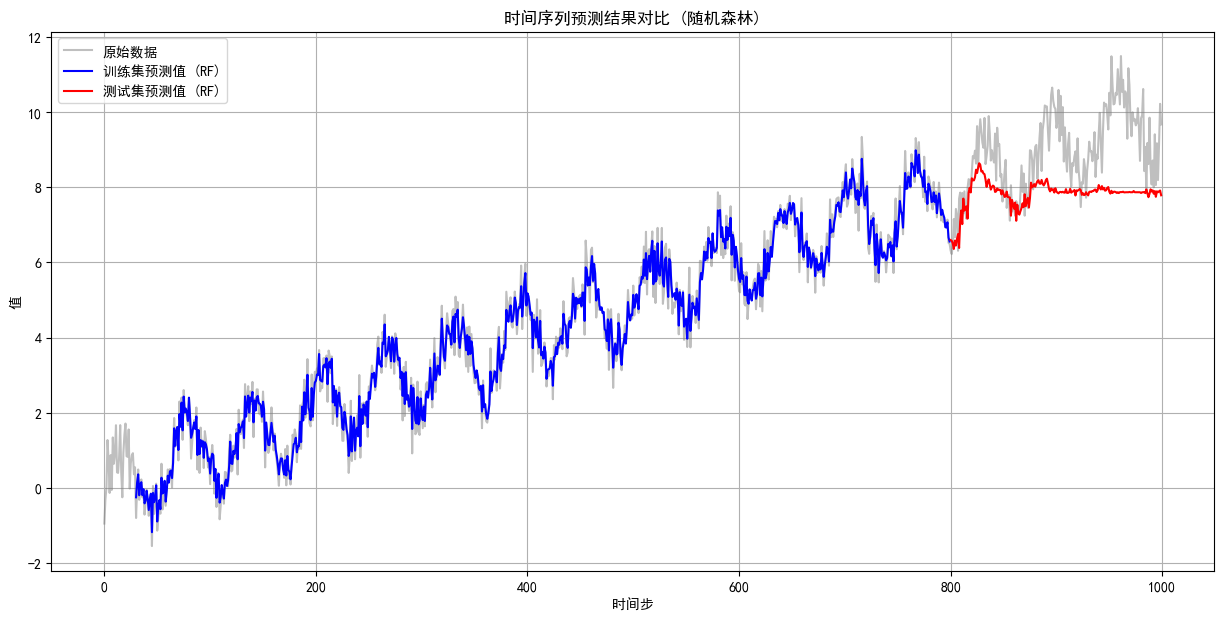

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# =============================================================
# ===== 步骤1：数据准备 (与之前完全相同) =====
# =============================================================

# 生成合成时间序列
x = np.linspace(0, 100, 1000)
y = np.sin(x) + 0.1 * x + np.random.normal(0, 0.5, 1000)

# 定义参数
train_size = int(len(y) * 0.8)
seq_length = 30

# 正确的数据标准化
train_data_raw = y[:train_size]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data_raw.reshape(-1, 1))
scaled_y = scaler.transform(y.reshape(-1, 1)).flatten()

# 创建时序数据集函数
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# 对完整数据应用滑动窗口
all_X, all_y = create_sequences(scaled_y, seq_length)

# 划分序列数据集
split_idx = train_size - seq_length
X_train_np = all_X[:split_idx]
y_train_np = all_y[:split_idx]
X_test_np = all_X[split_idx:]
y_test_np = all_y[split_idx:]

# =========================================================================
# ===== 步骤2：为机器学习模型准备数据 (关键区别点!) =====
# =========================================================================

# 1. 调整X的形状
# Scikit-learn的机器学习模型需要二维的输入: [样本数, 特征数]
# RNN需要的是三维输入: [样本数, 时间步长, 特征数]
# 我们需要将每个样本的 `seq_length` 个时间步“扁平化”成 `seq_length` 个特征。
# 原始形状: (770, 30, 1) or (770, 30) -> 目标形状: (770, 30)

# 获取样本数
n_samples_train = X_train_np.shape[0]
n_samples_test = X_test_np.shape[0]

# 将三维或二维的X reshape为二维
X_train_rf = X_train_np.reshape(n_samples_train, -1)
X_test_rf = X_test_np.reshape(n_samples_test, -1)

# y_train_np 和 y_test_np 已经是 (n_samples,) 的一维数组，可以直接使用。

print("为随机森林准备的 X_train 形状:", X_train_rf.shape) # (770, 30)
print("为随机森林准备的 y_train 形状:", y_train_np.shape)   # (770,)
print("为随机森林准备的 X_test 形状:", X_test_rf.shape)    # (200, 30)

# 注意：我们不再需要 PyTorch 的 Tensor, TensorDataset 和 DataLoader

# =============================================================
# ===== 步骤3：创建、训练和评估随机森林模型 =====
# =============================================================

# 1. 创建随机森林回归模型
# n_estimators: 森林中树的数量
# random_state: 保证每次运行结果一致，便于复现
# n_jobs=-1: 使用所有可用的CPU核心进行并行计算，加快训练速度
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 2. 训练模型
print("\n开始训练随机森林模型...")
rf_model.fit(X_train_rf, y_train_np)
print("模型训练完成！")

# 3. 做出预测
train_predict = rf_model.predict(X_train_rf)
test_predict = rf_model.predict(X_test_rf)

# 4. 反标准化预测结果，以便在原始尺度上进行比较
# scaler.inverse_transform 需要二维输入，所以先 reshape
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))

# 原始标签也需要反标准化
y_train_orig = scaler.inverse_transform(y_train_np.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test_np.reshape(-1, 1))

# 5. 计算均方根误差 (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_orig, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_orig, test_predict))
print(f"\n训练集 RMSE: {train_rmse:.4f}")
print(f"测试集 RMSE: {test_rmse:.4f}")


# =============================================================
# ===== 步骤4：可视化结果 =====
# =============================================================

plt.figure(figsize=(15, 7))
plt.plot(y, label='原始数据', color='gray', alpha=0.5)

# 绘制训练集的预测结果
train_predict_plot = np.empty_like(y)
train_predict_plot[:] = np.nan
train_predict_plot[seq_length : len(train_predict) + seq_length] = train_predict.flatten()
plt.plot(train_predict_plot, label='训练集预测值 (RF)', color='blue')

# 绘制测试集的预测结果
test_predict_plot = np.empty_like(y)
test_predict_plot[:] = np.nan
test_predict_plot[len(train_predict) + seq_length : len(y)] = test_predict.flatten()
plt.plot(test_predict_plot, label='测试集预测值 (RF)', color='red')

plt.title('时间序列预测结果对比 (随机森林)')
plt.xlabel('时间步')
plt.ylabel('值')
plt.legend()
plt.grid(True)
plt.show()

可以看到结果非常差

训练集表现 (蓝色部分): 完美拟合，近乎过拟合：在时间步0到800的训练区间内，蓝色的预测线几乎完美地覆盖了灰色的原始数据线。这说明随机森林模型非常强大，它有足够的能力去“背诵”或“记忆”训练数据。它学习到了在训练集范围内，什么样的输入窗口（X_train）对应什么样的输出值（y_train）。

测试集表现 (红色部分): 完全失败。当进入时间步800以后的测试集时，情况急转直下。初始阶段: 在测试集刚开始的一小段，模型似乎还能跟上，因为测试集初期的输入窗口和训练集末期的窗口非常相似。灾难性平线: 很快，模型的预测就变成了一条几乎水平的直线，完全忽略了原始数据仍在持续的上升趋势和周期性波动。



这个结果堪称教科书级别的案例，它完美地揭示了随机森林（以及所有基于决策树的模型）在处理带有趋势的时间序列数据时的根本性弱点。


这个失败的根源在于随机森林（或任何决策树模型）的工作原理：

决策树模型无法外推 (Cannot Extrapolate)。一个决策树通过一系列“是/否”问题来对数据进行划分。一个输入样本会顺着树的分支一直走到某个叶子节点。这个叶子节点的预测值，是所有在训练过程中落入这个叶子节点的训练样本标签(y)的平均值。随机森林是很多棵决策树的集合。它的最终预测值是所有树预测值的平均值。

这意味着，无论是单棵树还是整个森林，其最终的预测结果永远不可能超过它在训练集中见到过的最大目标值(y)，也不可能低于它见到过的最小目标值(y)。也就是说随机森林模型没有学到“趋势”这个抽象概念。它只学到了一个静态的映射：当输入在某个范围内时，输出就在某个范围内。当测试集的输入和输出都超出了它见过的范围时，它就只能给出它知识边界内的最大值，从而形成了一条无力的平线。

那么如何解决这个问题呢？我们下一次内容来提及